In [ ]:
import os
import torch
from pytorch_lightning import Trainer
from models.combined import CombinedMemeClassifier
import numpy as np
# import dataloader from pytorch
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
import mlflow 

from preprocessing.dataloaders import BinaryMemeDataset
from models.binary import BinaryMemeClassifier
from models.multi import ImagenetTransferLearning

Load models for inference

In [ ]:
mlflow.set_tracking_uri("http://127.0.0.1:8080")

binary_model = BinaryMemeClassifier.load_from_checkpoint("/home/hsdslab/murgi/meme-research-2024/src/models/best/binary_densenet121epoch=01-val_loss=0.00.ckpt")
template_model = ImagenetTransferLearning.load_from_checkpoint("/home/hsdslab/murgi/meme-research-2024/src/models/best/multi_densenet121epoch=09-val_loss=0.00.ckpt")

Set threshold to filter out templateless memes

In [20]:
binary_model.best_threshold = 0.6341
print(binary_model.best_threshold)

0.6341


Prepare dataloader

In [5]:

image_dir = "/home/hsdslab/murgi/SM-1000"

image_paths = os.listdir(image_dir)
image_paths = [os.path.join(image_dir, image_path) for image_path in image_paths]
image_paths

# create df

import pandas as pd

df = pd.DataFrame(image_paths, columns=["path"])
df["label"] = "asd"
df.to_parquet("sm-1000_image_paths.parquet")


In [7]:



transform = transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5325, 0.4980, 0.4715],[0.3409, 0.3384, 0.3465])
])


def my_collate_fn(batch):
    """ Filter out None samples """
    batch = [item for item in batch if item[0] is not None]
    if len(batch) == 0:
        return torch.Tensor(), torch.Tensor()  # Empty tensors if batch is fully invalid
    return torch.utils.data.dataloader.default_collate(batch)

dataset = BinaryMemeDataset(r'./sm-1000_image_paths.parquet', transform=transform)
dataloader = DataLoader(dataset, batch_size=48, shuffle=False, collate_fn=my_collate_fn, num_workers=4)

INFO:lightning_fabric.utilities.seed:Seed set to 42


In [21]:


combined_model = CombinedMemeClassifier(binary_model, template_model)

# Switch to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
combined_model = combined_model.to(device)


trainer = Trainer(accelerator='gpu')

predictions = trainer.predict(combined_model, dataloader)


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/home/hsdslab/murgi/meme-research-2024/meme-research/lib/python3.11/site-packages/PIL/Image.py:3218: DecompressionBombWarning: Image size (91242942 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [22]:

probs = [np.array(pred['meme_likelihood'].cpu()) for pred in predictions]
preds = [np.array(pred['template_output'].cpu()) for pred in predictions]
# flatten the list
probs = np.concatenate(probs)
preds = np.concatenate(preds)

columns = {
    "path": df["path"],
    "meme_likelihood": probs,
    "template_output": preds
}

preds_df = pd.DataFrame(columns)
preds_df


,path,meme_likelihood,template_output
0,/home/hsdslab/murgi/SM-1000/2022.05.04_527.jpg,0.995032,286
1,/home/hsdslab/murgi/SM-1000/2022.02.14_265.jpg,0.004008,-1
2,/home/hsdslab/murgi/SM-1000/2022.06.21_785.jpg,0.425803,-1
3,/home/hsdslab/murgi/SM-1000/2021.11.25_489.png,0.999649,877
4,/home/hsdslab/murgi/SM-1000/2022.08.28_964.jpg,0.241053,-1
...,...,...,...
995,/home/hsdslab/murgi/SM-1000/2022.09.17_407.jpg,0.999698,128
996,/home/hsdslab/murgi/SM-1000/2022.04.08_302.jpg,0.002981,-1
997,/home/hsdslab/murgi/SM-1000/2022.02.22_110.jpg,0.999871,455
998,/home/hsdslab/murgi/SM-1000/2022.09.20_932.jpg,0.999961,528


In [ ]:
imgflip_df = pd.read_parquet(r"../../data/imgflip/meme_entries.parquet")
labelencoder = LabelEncoder()
imgflip_df['template_id'] = labelencoder.fit_transform(imgflip_df['template_name'])

In [24]:
preds_df['predicted_template'] = preds_df.template_output.apply(lambda x: labelencoder.inverse_transform([x])[0] if x != -1 else "templateless")
preds_df

,path,meme_likelihood,template_output,predicted_template
0,/home/hsdslab/murgi/SM-1000/2022.05.04_527.jpg,0.995032,286,drake-yes-no-reverse
1,/home/hsdslab/murgi/SM-1000/2022.02.14_265.jpg,0.004008,-1,templateless
2,/home/hsdslab/murgi/SM-1000/2022.06.21_785.jpg,0.425803,-1,templateless
3,/home/hsdslab/murgi/SM-1000/2021.11.25_489.png,0.999649,877,socially-awesome-awkward-penguin
4,/home/hsdslab/murgi/SM-1000/2022.08.28_964.jpg,0.241053,-1,templateless
...,...,...,...,...
995,/home/hsdslab/murgi/SM-1000/2022.09.17_407.jpg,0.999698,128,black-scientist-finally-xium
996,/home/hsdslab/murgi/SM-1000/2022.04.08_302.jpg,0.002981,-1,templateless
997,/home/hsdslab/murgi/SM-1000/2022.02.22_110.jpg,0.999871,455,i-believe-in-supremacy
998,/home/hsdslab/murgi/SM-1000/2022.09.20_932.jpg,0.999961,528,joey-repeat-after-me


In [25]:
preds_df['id'] = preds_df.path.apply(lambda x: os.path.basename(os.path.splitext(x)[0]))
preds_df

,path,meme_likelihood,template_output,predicted_template,id
0,/home/hsdslab/murgi/SM-1000/2022.05.04_527.jpg,0.995032,286,drake-yes-no-reverse,2022.05.04_527
1,/home/hsdslab/murgi/SM-1000/2022.02.14_265.jpg,0.004008,-1,templateless,2022.02.14_265
2,/home/hsdslab/murgi/SM-1000/2022.06.21_785.jpg,0.425803,-1,templateless,2022.06.21_785
3,/home/hsdslab/murgi/SM-1000/2021.11.25_489.png,0.999649,877,socially-awesome-awkward-penguin,2021.11.25_489
4,/home/hsdslab/murgi/SM-1000/2022.08.28_964.jpg,0.241053,-1,templateless,2022.08.28_964
...,...,...,...,...,...
995,/home/hsdslab/murgi/SM-1000/2022.09.17_407.jpg,0.999698,128,black-scientist-finally-xium,2022.09.17_407
996,/home/hsdslab/murgi/SM-1000/2022.04.08_302.jpg,0.002981,-1,templateless,2022.04.08_302
997,/home/hsdslab/murgi/SM-1000/2022.02.22_110.jpg,0.999871,455,i-believe-in-supremacy,2022.02.22_110
998,/home/hsdslab/murgi/SM-1000/2022.09.20_932.jpg,0.999961,528,joey-repeat-after-me,2022.09.20_932


In [19]:
gt_df = pd.read_parquet(r'../../data\sm\predictions\sm-1000.parquet')
gt_df

,image_id,template_true,binary_true_encoded,sparse_prediction,phash_prediction,cnn_prediction,rnn_prediction,touch_prediction,touch_binary,sparse_binary,phash_binary,cnn_binary,rnn_binary,path,phash
0,2021.11.15_889,templateless,0,templateless,templateless,scared-hamster,None,None,NaN,NaN,NaN,NaN,NaN,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,73e0d886a55e99b1
1,2021.11.19_551,templateless,0,templateless,templateless,templateless,None,None,NaN,NaN,NaN,NaN,NaN,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,f1c93e1e8f70c1e0
2,2021.11.20_438,templateless,0,can-i-offer-you-an-egg-in-these-trying-times,templateless,think-mark-think,None,None,NaN,NaN,NaN,NaN,NaN,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,1de50b0176b0eebc
3,2021.11.20_858,templateless,0,scumbag-brain,templateless,turn-up-the-volume,None,None,NaN,NaN,NaN,NaN,NaN,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,777c098782a9f259
4,2021.11.21_500,gus-fring-we-are-not-the-same,1,templateless,gus-fring-we-are-not-the-same,gus-fring-we-are-not-the-same,None,None,NaN,NaN,NaN,NaN,NaN,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,6761a8de031bfc16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,coronavirus-7244,templateless,0,templateless,templateless,templateless,templateless,templateless,0.0,0.0,0.0,0.0,0.0,D:/Murgi/Facebook2023/Facebook2023/coronavirus...,b31f52706cc76670
996,imemeit_added-15546,templateless,0,templateless,templateless,templateless,templateless,templateless,0.0,0.0,0.0,0.0,0.0,D:/Murgi/Facebook2023/Facebook2023/imemeit_add...,23d9caa73c1c87e2
997,imemeit_added-16353,templateless,0,templateless,templateless,keep-calm-and-carry-on-purple,templateless,templateless,0.0,0.0,0.0,1.0,0.0,D:/Murgi/Facebook2023/Facebook2023/imemeit_add...,2b83545abc0bd4bd
998,verynicememethanks_added-47232,templateless,0,templateless,templateless,wanted-poster,templateless,templateless,0.0,0.0,0.0,1.0,0.0,D:/Murgi/Facebook2023/Facebook2023/verynicemem...,1595ebb5b6914968


In [33]:
gt_df = gt_df.merge(preds_df[['id', 'predicted_template', 'meme_likelihood']], right_on='id', left_on='image_id' ,how='left')
gt_df

,image_id,template_true,binary_true_encoded,sparse_prediction,phash_prediction,cnn_prediction,rnn_prediction,touch_prediction,touch_binary,sparse_binary,phash_binary,cnn_binary,rnn_binary,path,phash,id,predicted_template,meme_likelihood
0,2021.11.15_889,templateless,0,templateless,templateless,scared-hamster,None,None,NaN,NaN,NaN,NaN,NaN,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,73e0d886a55e99b1,2021.11.15_889,scared-hamster,1.000000
1,2021.11.19_551,templateless,0,templateless,templateless,templateless,None,None,NaN,NaN,NaN,NaN,NaN,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,f1c93e1e8f70c1e0,2021.11.19_551,templateless,0.191793
2,2021.11.20_438,templateless,0,can-i-offer-you-an-egg-in-these-trying-times,templateless,think-mark-think,None,None,NaN,NaN,NaN,NaN,NaN,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,1de50b0176b0eebc,2021.11.20_438,think-mark-think,1.000000
3,2021.11.20_858,templateless,0,scumbag-brain,templateless,turn-up-the-volume,None,None,NaN,NaN,NaN,NaN,NaN,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,777c098782a9f259,2021.11.20_858,turn-up-the-volume,0.649783
4,2021.11.21_500,gus-fring-we-are-not-the-same,1,templateless,gus-fring-we-are-not-the-same,gus-fring-we-are-not-the-same,None,None,NaN,NaN,NaN,NaN,NaN,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,6761a8de031bfc16,2021.11.21_500,templateless,0.526493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,coronavirus-7244,templateless,0,templateless,templateless,templateless,templateless,templateless,0.0,0.0,0.0,0.0,0.0,D:/Murgi/Facebook2023/Facebook2023/coronavirus...,b31f52706cc76670,coronavirus-7244,templateless,0.000002
996,imemeit_added-15546,templateless,0,templateless,templateless,templateless,templateless,templateless,0.0,0.0,0.0,0.0,0.0,D:/Murgi/Facebook2023/Facebook2023/imemeit_add...,23d9caa73c1c87e2,imemeit_added-15546,templateless,0.003012
997,imemeit_added-16353,templateless,0,templateless,templateless,keep-calm-and-carry-on-purple,templateless,templateless,0.0,0.0,0.0,1.0,0.0,D:/Murgi/Facebook2023/Facebook2023/imemeit_add...,2b83545abc0bd4bd,imemeit_added-16353,keep-calm-and-carry-on-purple,0.999935
998,verynicememethanks_added-47232,templateless,0,templateless,templateless,wanted-poster,templateless,templateless,0.0,0.0,0.0,1.0,0.0,D:/Murgi/Facebook2023/Facebook2023/verynicemem...,1595ebb5b6914968,verynicememethanks_added-47232,wanted-poster,0.746369


In [28]:
gt_df.rename(columns={'predicted_template': 'cnn_threshold_prediction'}, inplace=True)

In [29]:
gt_df['cnn_threshold_binary'] = gt_df.cnn_threshold_prediction.apply(lambda x: 1 if x != "templateless" else 0)
gt_df["cnn_binary"] = gt_df.cnn_prediction.apply(lambda x: 1 if x != "templateless" else 0)
gt_df.cnn_binary.value_counts(), gt_df.cnn_threshold_binary.value_counts()

(cnn_binary
 1    681
 0    319
 Name: count, dtype: int64,
 cnn_threshold_binary
 1    660
 0    340
 Name: count, dtype: int64)

CNN if threshold = 0.5


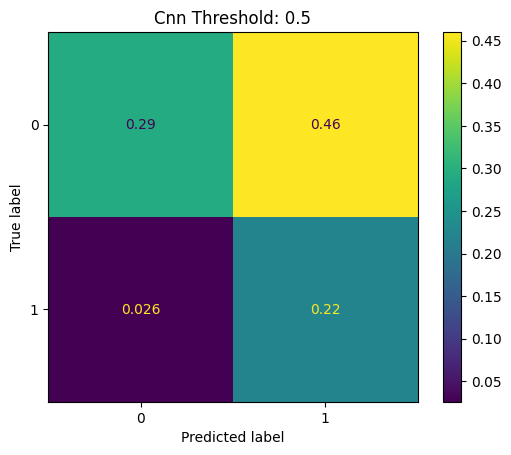

              precision    recall  f1-score   support

           0       0.92      0.39      0.55       753
           1       0.32      0.89      0.48       247

    accuracy                           0.51      1000
   macro avg       0.62      0.64      0.51      1000
weighted avg       0.77      0.51      0.53      1000

CNN if threshold = 0.63411576


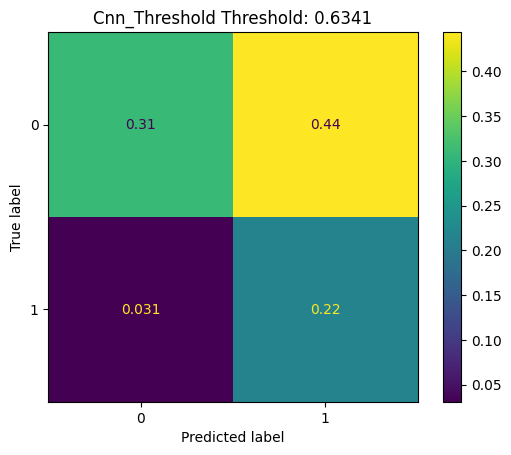

              precision    recall  f1-score   support

           0       0.91      0.41      0.57       753
           1       0.33      0.87      0.48       247

    accuracy                           0.53      1000
   macro avg       0.62      0.64      0.52      1000
weighted avg       0.77      0.53      0.54      1000



In [31]:


def calc_binary_metrics_for_model_v2(df,model_name:str, threshold=None, dict_format=False):
    temp = df
    temp[f"{model_name}_binary"] = temp[f"{model_name}_prediction"].apply(lambda x: 0 if x == 'templateless' else 1)
    y_true = temp['binary_true_encoded'].values
    y_pred = temp[f"{model_name}_binary"].values
    cm_1 = confusion_matrix(y_true, y_pred, normalize='all')
    # cm_2 = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_1)
    # disp_2 = ConfusionMatrixDisplay(confusion_matrix=cm_2)
    disp.plot()
    plt.title(f'{model_name.title()} Threshold: {threshold}')
    plt.grid(False)
    plt.show()
    return classification_report(y_true,y_pred, output_dict=dict_format)

print("CNN if threshold = 0.5")
print(calc_binary_metrics_for_model_v2(gt_df, 'cnn',0.5))
print("CNN if threshold = 0.63411576")
print(calc_binary_metrics_for_model_v2(gt_df, 'cnn_threshold',binary_model.best_threshold))

In [34]:

# Plot the histograms
plt.hist(gt_df[gt_df['binary_true_encoded']==1]['meme_likelihood'], color='green', alpha=0.5, label='Templated')
plt.hist(gt_df[gt_df['binary_true_encoded']==0]['meme_likelihood'], color='red', alpha=0.5, label='Templateless')

# Add labels and title
plt.xlabel('Max Probability')
plt.ylabel('Frequency')
plt.title('Histogram of Max Probability')
plt.yscale('log')
# Add legend
plt.legend()

# Show the plot
plt.show()


,image_id,template_true,binary_true_encoded,sparse_prediction,phash_prediction,cnn_prediction,rnn_prediction,touch_prediction,touch_binary,sparse_binary,phash_binary,cnn_binary,rnn_binary,path,phash,id,predicted_template,meme_likelihood
0,2021.11.15_889,templateless,0,templateless,templateless,scared-hamster,None,None,NaN,NaN,NaN,NaN,NaN,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,73e0d886a55e99b1,2021.11.15_889,scared-hamster,1.000000
1,2021.11.19_551,templateless,0,templateless,templateless,templateless,None,None,NaN,NaN,NaN,NaN,NaN,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,f1c93e1e8f70c1e0,2021.11.19_551,templateless,0.191793
2,2021.11.20_438,templateless,0,can-i-offer-you-an-egg-in-these-trying-times,templateless,think-mark-think,None,None,NaN,NaN,NaN,NaN,NaN,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,1de50b0176b0eebc,2021.11.20_438,think-mark-think,1.000000
3,2021.11.20_858,templateless,0,scumbag-brain,templateless,turn-up-the-volume,None,None,NaN,NaN,NaN,NaN,NaN,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,777c098782a9f259,2021.11.20_858,turn-up-the-volume,0.649783
4,2021.11.21_500,gus-fring-we-are-not-the-same,1,templateless,gus-fring-we-are-not-the-same,gus-fring-we-are-not-the-same,None,None,NaN,NaN,NaN,NaN,NaN,C:/Users/molontay/Murgi/data/Memes2022Final2/M...,6761a8de031bfc16,2021.11.21_500,templateless,0.526493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,coronavirus-7244,templateless,0,templateless,templateless,templateless,templateless,templateless,0.0,0.0,0.0,0.0,0.0,D:/Murgi/Facebook2023/Facebook2023/coronavirus...,b31f52706cc76670,coronavirus-7244,templateless,0.000002
996,imemeit_added-15546,templateless,0,templateless,templateless,templateless,templateless,templateless,0.0,0.0,0.0,0.0,0.0,D:/Murgi/Facebook2023/Facebook2023/imemeit_add...,23d9caa73c1c87e2,imemeit_added-15546,templateless,0.003012
997,imemeit_added-16353,templateless,0,templateless,templateless,keep-calm-and-carry-on-purple,templateless,templateless,0.0,0.0,0.0,1.0,0.0,D:/Murgi/Facebook2023/Facebook2023/imemeit_add...,2b83545abc0bd4bd,imemeit_added-16353,keep-calm-and-carry-on-purple,0.999935
998,verynicememethanks_added-47232,templateless,0,templateless,templateless,wanted-poster,templateless,templateless,0.0,0.0,0.0,1.0,0.0,D:/Murgi/Facebook2023/Facebook2023/verynicemem...,1595ebb5b6914968,verynicememethanks_added-47232,wanted-poster,0.746369
